Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 17 files belonging to 5 classes.
Val Classes available:  ['0' '1' '10' '11' '12']
Predictions:  [ 4  1  2  2  1 10 10 11 11 11 11 11 12 12 12 12 12]
Ground truth:  [ 0  1  1  1  1 10 10 11 11 11 11 11 12 12 12 12 12]
Accuracy:  0.8235294


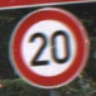

Class ID: 4 Class Name: Speed limit (70km/h)


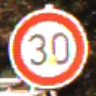

Class ID: 2 Class Name: Speed limit (50km/h)


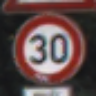

Class ID: 2 Class Name: Speed limit (50km/h)


In [33]:
# This is the seed for your validation pipeline. It will allow you to load a model and run it on data from a directory.

# //////////////////////////////////////// Setup

import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

# //////////////////////////////////////// Load model
model_name = "Model_V0_E50S96"
import_path = "./trained_models/{}".format(model_name)
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
val_data_root = "./safetyBatches/Batch_0/"
train_data_root = "./GTSRB_dataset/Train/"

batch_size = 32
img_height = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3
img_width = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3

train_ds  = tf.keras.utils.image_dataset_from_directory(train_data_root)
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)

test_ds  = unedited_dataset = tf.keras.utils.image_dataset_from_directory(
    val_data_root,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

# get the ground truth labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Mapping test labels to the folder names instead of the index
for i in range(0, len(test_labels)):
    test_labels[i] = int(class_names[test_labels[i]])

# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

print("Predictions: ", predictions)
print("Ground truth: ", test_labels)

# //////////////////////////////////////// Let the validation begin
# Probably you will want to at least migrate these to another script or class when this grows..
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

print("Accuracy: ", accuracy(predictions, test_labels))

class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")

for picture in range(0, len(predictions)):
    if(predictions[picture] != test_labels[picture]):
        for batch in unedited_dataset.take(1):
            images, _ = batch
            image = images[picture]
            image = np.array(image)
            pil_image = Image.fromarray((image).astype(np.uint8))
            display(pil_image)
            print(f'Class ID: {predictions[picture]} Class Name: {class_names_df["SignName"][predictions[picture]]}')


Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 50 files belonging to 1 classes.
Val Classes available:  ['42']
Predictions:  [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42 42 42 42  6 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42]
Ground truth:  [42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42]
Accuracy:  0.98
Plotting the false predicted pictures


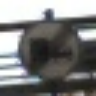

Class ID: 6 Class Name: End of speed limit (80km/h)


In [44]:
# //////////////////////////////////////// Load model
model_name = "Model_V0_E50S96"
import_path = "./trained_models/{}".format(model_name)
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
val_data_root = "./safetyBatches/Batch_1/"
train_data_root = "./GTSRB_dataset/Train/"

batch_size = 50
img_height = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3
img_width = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3

train_ds  = tf.keras.utils.image_dataset_from_directory(train_data_root)
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)

test_ds  = unedited_dataset = tf.keras.utils.image_dataset_from_directory(
    val_data_root,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

# get the ground truth labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Mapping test labels to the folder names instead of the index
for i in range(0, len(test_labels)):
    test_labels[i] = int(class_names[test_labels[i]])

# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

print("Predictions: ", predictions)
print("Ground truth: ", test_labels)

# //////////////////////////////////////// Let the validation begin
# Probably you will want to at least migrate these to another script or class when this grows..
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

print("Accuracy: ", accuracy(predictions, test_labels))

class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")

print("Plotting the false predicted pictures")
for picture in range(0, len(predictions)):

    if(predictions[picture] != test_labels[picture]):

        for batch in unedited_dataset.take(1):
            images, _ = batch
            image = images[picture]
            image = np.array(image)
            pil_image = Image.fromarray((image).astype(np.uint8))
            display(pil_image)
            print(f'Class ID: {predictions[picture]} Class Name: {class_names_df["SignName"][predictions[picture]]}')


Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 2100 files belonging to 1 classes.
Val Classes available:  ['12']
Predictions:  [12 12 12 ... 12 12 12]
Ground truth:  [12 12 12 ... 12 12 12]
Accuracy:  0.98761904
Plotting the false predicted pictures


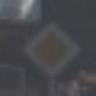

Class ID: 38 Class Name: Keep right


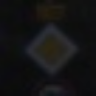

Class ID: 10 Class Name: No passing for vehicles over 3.5 metric tons


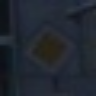

Class ID: 38 Class Name: Keep right


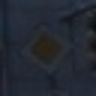

Class ID: 25 Class Name: Road work


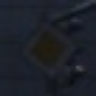

Class ID: 38 Class Name: Keep right


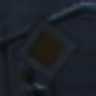

Class ID: 10 Class Name: No passing for vehicles over 3.5 metric tons


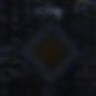

Class ID: 38 Class Name: Keep right


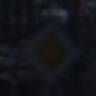

Class ID: 38 Class Name: Keep right


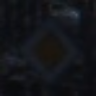

Class ID: 38 Class Name: Keep right


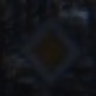

Class ID: 38 Class Name: Keep right


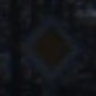

Class ID: 25 Class Name: Road work


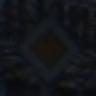

Class ID: 3 Class Name: Speed limit (60km/h)


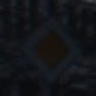

Class ID: 25 Class Name: Road work


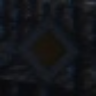

Class ID: 25 Class Name: Road work


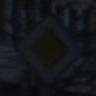

Class ID: 25 Class Name: Road work


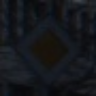

Class ID: 25 Class Name: Road work


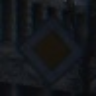

Class ID: 25 Class Name: Road work


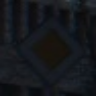

Class ID: 25 Class Name: Road work


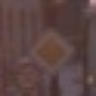

Class ID: 25 Class Name: Road work


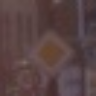

Class ID: 18 Class Name: General caution


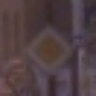

Class ID: 18 Class Name: General caution


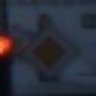

Class ID: 30 Class Name: Beware of ice/snow


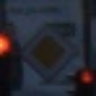

Class ID: 10 Class Name: No passing for vehicles over 3.5 metric tons


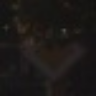

Class ID: 35 Class Name: Ahead only


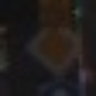

Class ID: 38 Class Name: Keep right


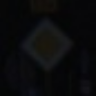

Class ID: 18 Class Name: General caution


In [46]:
# //////////////////////////////////////// Load model
model_name = "Model_V0_E50S96"
import_path = "./trained_models/{}".format(model_name)
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
val_data_root = "./safetyBatches/Batch_2/"
train_data_root = "./GTSRB_dataset/Train/"

batch_size = 2100
img_height = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3
img_width = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3

train_ds  = tf.keras.utils.image_dataset_from_directory(train_data_root)
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)

test_ds  = unedited_dataset = tf.keras.utils.image_dataset_from_directory(
    val_data_root,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

# get the ground truth labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Mapping test labels to the folder names instead of the index
for i in range(0, len(test_labels)):
    test_labels[i] = int(class_names[test_labels[i]])

# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

print("Predictions: ", predictions)
print("Ground truth: ", test_labels)

# //////////////////////////////////////// Let the validation begin
# Probably you will want to at least migrate these to another script or class when this grows..
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

print("Accuracy: ", accuracy(predictions, test_labels))

class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")

print("Plotting the false predicted pictures")
for picture in range(0, len(predictions)):

    if(predictions[picture] != test_labels[picture]):

        for batch in unedited_dataset.take(1):
            images, _ = batch
            image = images[picture]
            image = np.array(image)
            pil_image = Image.fromarray((image).astype(np.uint8))
            display(pil_image)
            print(f'Class ID: {predictions[picture]} Class Name: {class_names_df["SignName"][predictions[picture]]}')


In [77]:
# import os
# from PIL import Image
#
# def ppm_to_png(file_path):
#     # Konvertiere PPM-Datei in PNG-Datei
#     img = Image.open(file_path)
#     img.save(file_path.replace(".ppm", ".png"), "PNG")
#     os.remove(file_path)
#
# def convert_folder(folder_path):
#     # Gehe durch alle Dateien und Ordner im aktuellen Ordner
#     for item in os.listdir(folder_path):
#         item_path = os.path.join(folder_path, item)
#         if os.path.isdir(item_path):
#             # Wenn es sich um einen Ordner handelt, rufe die Funktion rekursiv auf
#             convert_folder(item_path)
#         elif item_path.endswith(".ppm"):
#             # Wenn es sich um eine PPM-Datei handelt, konvertiere sie
#             ppm_to_png(item_path)
#
# # Starte die Konvertierung im aktuellen Verzeichnis
# convert_folder("./safetyBatches/Batch_3/GTSRB/Final_Training/Images")
print("wooow klasse ChatGBT")


Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 39209 files belonging to 43 classes.
Val Classes available:  ['00000' '00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008'
 '00009' '00010' '00011' '00012' '00013' '00014' '00015' '00016' '00017'
 '00018' '00019' '00020' '00021' '00022' '00023' '00024' '00025' '00026'
 '00027' '00028' '00029' '00030' '00031' '00032' '00033' '00034' '00035'
 '00036' '00037' '00038' '00039' '00040' '00041' '00042']
Predictions:  [ 0  0  0 ... 42 42 42]
Ground truth:  [ 0  0  0 ... 42 42 42]
Accuracy:  0.9868653
Plotting the false predicted pictures


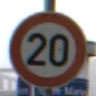

Class ID: 1 Class Name: Speed limit (30km/h)


In [78]:
# //////////////////////////////////////// Load model
model_name = "Model_V0_E50S96"
import_path = "./trained_models/{}".format(model_name)
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
val_data_root = "./safetyBatches/Batch_3/"
train_data_root = "./GTSRB_dataset/Train/"

batch_size = 100
img_height = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3
img_width = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3

train_ds  = tf.keras.utils.image_dataset_from_directory(train_data_root)
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)

test_ds  = unedited_dataset = tf.keras.utils.image_dataset_from_directory(
    val_data_root,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

# get the ground truth labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Mapping test labels to the folder names instead of the index
for i in range(0, len(test_labels)):
    test_labels[i] = int(class_names[test_labels[i]])

# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

print("Predictions: ", predictions)
print("Ground truth: ", test_labels)

# //////////////////////////////////////// Let the validation begin
# Probably you will want to at least migrate these to another script or class when this grows..
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

print("Accuracy: ", accuracy(predictions, test_labels))

class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")

print("Plotting the false predicted pictures")
for picture in range(0, 100):

    if(predictions[picture] != test_labels[picture]):

        for batch in unedited_dataset.take(1):
            images, _ = batch
            image = images[picture]
            image = np.array(image)
            pil_image = Image.fromarray((image).astype(np.uint8))
            display(pil_image)
            print(f'Class ID: {predictions[picture]} Class Name: {class_names_df["SignName"][predictions[picture]]}')


Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 210 files belonging to 1 classes.
Val Classes available:  ['0']
Predictions:  [ 2  3  1  2  2  2  2  2  2  2  2  2  2  1  2  2  2  2  2 39  2  2  2  2
  2  3  4  4  3  3  2 40  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  4  3  3  3  3  3  4  4  4  4  4
  4  3  4  4  4  3  1  4  4  4  3  9  3  2  2  2  3  3  1  1  1  1  1  1
  1  2  4  4  1  4  3  4  3  4  3  4  4  4  3  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  1  4  1  4  1  1  3  1  1  1  1  1  1  2  1  1  1
  1  2  1  3  3  3  4  3  4  4  7  3  3  7  1  4  4  4  5  3  4  5  4  4
  3  4  4  4  4  4  2  2  3  1  2  2 38 10  2 20  4  3  3  3  3  4  5  4
  4  4  3  3  3  3  3  1  1  1  3  3  1  1 35  7  4  1

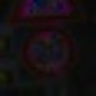

Class ID: 2 Class Name: Speed limit (50km/h)


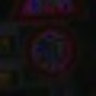

Class ID: 3 Class Name: Speed limit (60km/h)


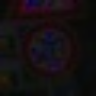

Class ID: 1 Class Name: Speed limit (30km/h)


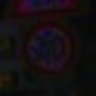

Class ID: 2 Class Name: Speed limit (50km/h)


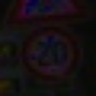

Class ID: 2 Class Name: Speed limit (50km/h)


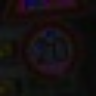

Class ID: 2 Class Name: Speed limit (50km/h)


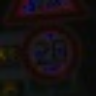

Class ID: 2 Class Name: Speed limit (50km/h)


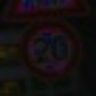

Class ID: 2 Class Name: Speed limit (50km/h)


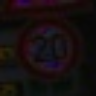

Class ID: 2 Class Name: Speed limit (50km/h)


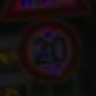

Class ID: 2 Class Name: Speed limit (50km/h)


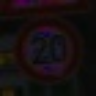

Class ID: 2 Class Name: Speed limit (50km/h)


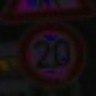

Class ID: 2 Class Name: Speed limit (50km/h)


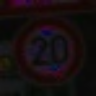

Class ID: 2 Class Name: Speed limit (50km/h)


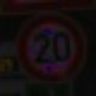

Class ID: 1 Class Name: Speed limit (30km/h)


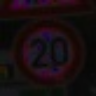

Class ID: 2 Class Name: Speed limit (50km/h)


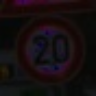

Class ID: 2 Class Name: Speed limit (50km/h)


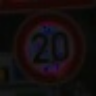

Class ID: 2 Class Name: Speed limit (50km/h)


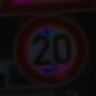

Class ID: 2 Class Name: Speed limit (50km/h)


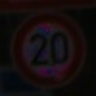

Class ID: 2 Class Name: Speed limit (50km/h)


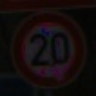

Class ID: 39 Class Name: Keep left


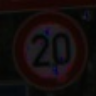

Class ID: 2 Class Name: Speed limit (50km/h)


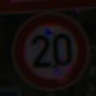

Class ID: 2 Class Name: Speed limit (50km/h)


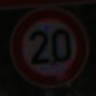

Class ID: 2 Class Name: Speed limit (50km/h)


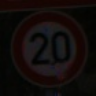

Class ID: 2 Class Name: Speed limit (50km/h)


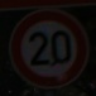

Class ID: 2 Class Name: Speed limit (50km/h)


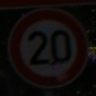

Class ID: 3 Class Name: Speed limit (60km/h)


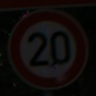

Class ID: 4 Class Name: Speed limit (70km/h)


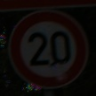

Class ID: 4 Class Name: Speed limit (70km/h)


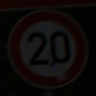

Class ID: 3 Class Name: Speed limit (60km/h)


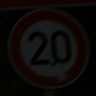

Class ID: 3 Class Name: Speed limit (60km/h)


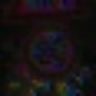

Class ID: 2 Class Name: Speed limit (50km/h)


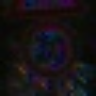

Class ID: 40 Class Name: Roundabout mandatory


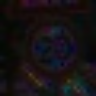

Class ID: 2 Class Name: Speed limit (50km/h)


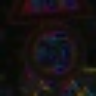

Class ID: 2 Class Name: Speed limit (50km/h)


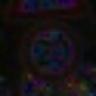

Class ID: 2 Class Name: Speed limit (50km/h)


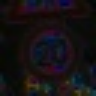

Class ID: 2 Class Name: Speed limit (50km/h)


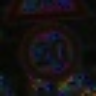

Class ID: 2 Class Name: Speed limit (50km/h)


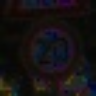

Class ID: 2 Class Name: Speed limit (50km/h)


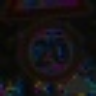

Class ID: 2 Class Name: Speed limit (50km/h)


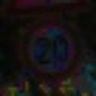

Class ID: 2 Class Name: Speed limit (50km/h)


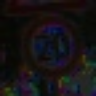

Class ID: 2 Class Name: Speed limit (50km/h)


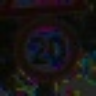

Class ID: 2 Class Name: Speed limit (50km/h)


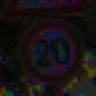

Class ID: 2 Class Name: Speed limit (50km/h)


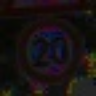

Class ID: 2 Class Name: Speed limit (50km/h)


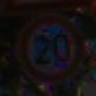

Class ID: 2 Class Name: Speed limit (50km/h)


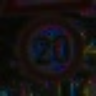

Class ID: 2 Class Name: Speed limit (50km/h)


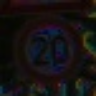

Class ID: 2 Class Name: Speed limit (50km/h)


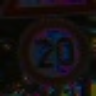

Class ID: 2 Class Name: Speed limit (50km/h)


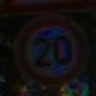

Class ID: 2 Class Name: Speed limit (50km/h)


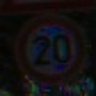

Class ID: 2 Class Name: Speed limit (50km/h)


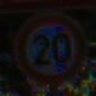

Class ID: 2 Class Name: Speed limit (50km/h)


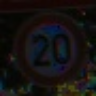

Class ID: 2 Class Name: Speed limit (50km/h)


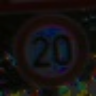

Class ID: 2 Class Name: Speed limit (50km/h)


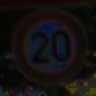

Class ID: 2 Class Name: Speed limit (50km/h)


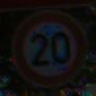

Class ID: 2 Class Name: Speed limit (50km/h)


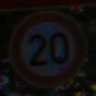

Class ID: 2 Class Name: Speed limit (50km/h)


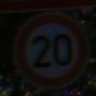

Class ID: 2 Class Name: Speed limit (50km/h)


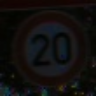

Class ID: 2 Class Name: Speed limit (50km/h)


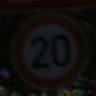

Class ID: 2 Class Name: Speed limit (50km/h)


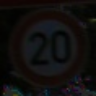

Class ID: 2 Class Name: Speed limit (50km/h)


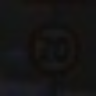

Class ID: 3 Class Name: Speed limit (60km/h)


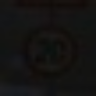

Class ID: 4 Class Name: Speed limit (70km/h)


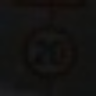

Class ID: 3 Class Name: Speed limit (60km/h)


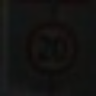

Class ID: 3 Class Name: Speed limit (60km/h)


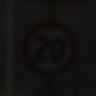

Class ID: 3 Class Name: Speed limit (60km/h)


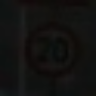

Class ID: 3 Class Name: Speed limit (60km/h)


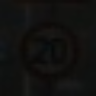

Class ID: 3 Class Name: Speed limit (60km/h)


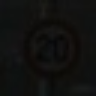

Class ID: 4 Class Name: Speed limit (70km/h)


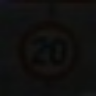

Class ID: 4 Class Name: Speed limit (70km/h)


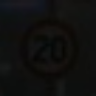

Class ID: 4 Class Name: Speed limit (70km/h)


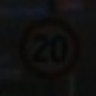

Class ID: 4 Class Name: Speed limit (70km/h)


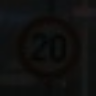

Class ID: 4 Class Name: Speed limit (70km/h)


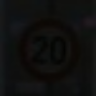

Class ID: 4 Class Name: Speed limit (70km/h)


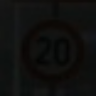

Class ID: 3 Class Name: Speed limit (60km/h)


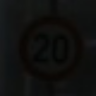

Class ID: 4 Class Name: Speed limit (70km/h)


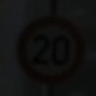

Class ID: 4 Class Name: Speed limit (70km/h)


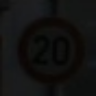

Class ID: 4 Class Name: Speed limit (70km/h)


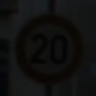

Class ID: 3 Class Name: Speed limit (60km/h)


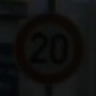

Class ID: 1 Class Name: Speed limit (30km/h)


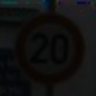

Class ID: 4 Class Name: Speed limit (70km/h)


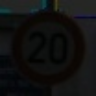

Class ID: 4 Class Name: Speed limit (70km/h)


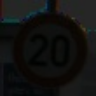

Class ID: 4 Class Name: Speed limit (70km/h)


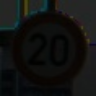

Class ID: 3 Class Name: Speed limit (60km/h)


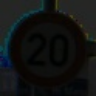

Class ID: 9 Class Name: No passing


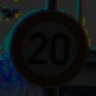

Class ID: 3 Class Name: Speed limit (60km/h)


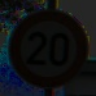

Class ID: 2 Class Name: Speed limit (50km/h)


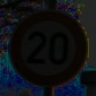

Class ID: 2 Class Name: Speed limit (50km/h)


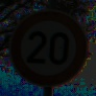

Class ID: 2 Class Name: Speed limit (50km/h)


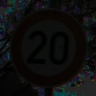

Class ID: 3 Class Name: Speed limit (60km/h)


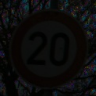

Class ID: 3 Class Name: Speed limit (60km/h)


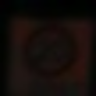

Class ID: 1 Class Name: Speed limit (30km/h)


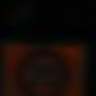

Class ID: 1 Class Name: Speed limit (30km/h)


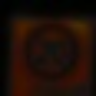

Class ID: 1 Class Name: Speed limit (30km/h)


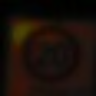

Class ID: 1 Class Name: Speed limit (30km/h)


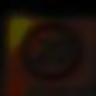

Class ID: 1 Class Name: Speed limit (30km/h)


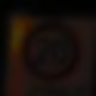

Class ID: 1 Class Name: Speed limit (30km/h)


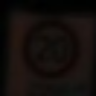

Class ID: 1 Class Name: Speed limit (30km/h)


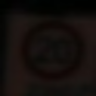

Class ID: 2 Class Name: Speed limit (50km/h)


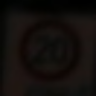

Class ID: 4 Class Name: Speed limit (70km/h)


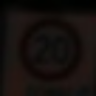

Class ID: 4 Class Name: Speed limit (70km/h)


In [79]:
# //////////////////////////////////////// Load model
model_name = "Model_V0_E50S96"
import_path = "./trained_models/{}".format(model_name)
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
val_data_root = "./safetyBatches/Batch_4/"
train_data_root = "./GTSRB_dataset/Train/"

batch_size = 100
img_height = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3
img_width = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3

train_ds  = tf.keras.utils.image_dataset_from_directory(train_data_root)
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)

test_ds  = unedited_dataset = tf.keras.utils.image_dataset_from_directory(
    val_data_root,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

# get the ground truth labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Mapping test labels to the folder names instead of the index
for i in range(0, len(test_labels)):
    test_labels[i] = int(class_names[test_labels[i]])

# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

print("Predictions: ", predictions)
print("Ground truth: ", test_labels)

# //////////////////////////////////////// Let the validation begin
# Probably you will want to at least migrate these to another script or class when this grows..
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

print("Accuracy: ", accuracy(predictions, test_labels))

class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")

print("Plotting the false predicted pictures")
for picture in range(0, 100):

    if(predictions[picture] != test_labels[picture]):

        for batch in unedited_dataset.take(1):
            images, _ = batch
            image = images[picture]
            image = np.array(image)
            pil_image = Image.fromarray((image).astype(np.uint8))
            display(pil_image)
            print(f'Class ID: {predictions[picture]} Class Name: {class_names_df["SignName"][predictions[picture]]}')


Found 39209 files belonging to 43 classes.
Train Classes available:  ['0' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '5' '6' '7' '8' '9']
Found 733 files belonging to 1 classes.
Val Classes available:  ['39']
Predictions:  [12 16 12  4 12 32 12 18 25 12 16 12 16 13  4  4 16 12 32 12 12 13 18 25
 12 12 12 41 13  4 18 12  4 12 13  1 12 12 16 10 12 13 12 13 12 12 12 12
 12 16 12 12 12 12 12 13 12 12 12  4  4  4  4 23 22 12 12  4 13 12 12 12
 13 12  4  4 12 12 12 16 12 12 13 13 12 12  9 12 12 12 16 38  9 38 12 16
 12 12 12 12 12 12 12  4 12 13 12 10  4 13 33 18 12 12  4 18 12  5 13 13
 12 12 12 12 12  5  2 12 12 12 11  2 38 16  4 18 18 13 38 12 12 12 12 12
  9 16 12 38 12 12 12 12 13 13 12 12 13 38 12 12 12 12 12 12  4 12 13 12
 12 12 12 13 12 13 13 12 34 12 13 12 13 13 16 18 12 12 12  5 10 12 12 12
 13 12 18 12 10 38 13 12  4  4 10 12  4 13 12 12 38 1

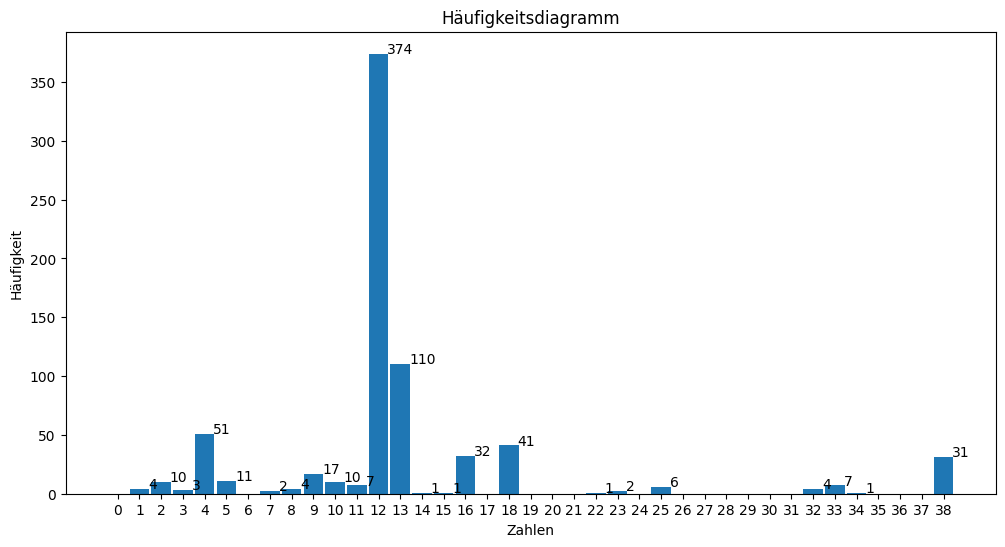

Plotting the false predicted pictures


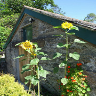

Class ID: 13 Class Name: Yield


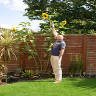

Class ID: 13 Class Name: Yield


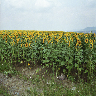

Class ID: 13 Class Name: Yield


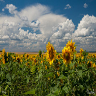

Class ID: 13 Class Name: Yield


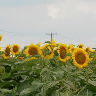

Class ID: 13 Class Name: Yield


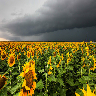

Class ID: 13 Class Name: Yield


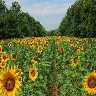

Class ID: 13 Class Name: Yield


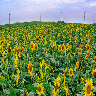

Class ID: 13 Class Name: Yield


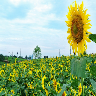

Class ID: 13 Class Name: Yield


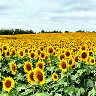

Class ID: 13 Class Name: Yield


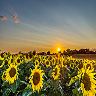

Class ID: 13 Class Name: Yield


In [76]:
# //////////////////////////////////////// Load model
model_name = "Model_V0_E50S96"
import_path = "./trained_models/{}".format(model_name)
model = tf.keras.models.load_model(import_path)

# //////////////////////////////////////// Load data
# You will need to unzip the respective batch folders.
# Obviously Batch_0 is not sufficient for testing as you will soon find out.
val_data_root = "./safetyBatches/Batch_5/"
train_data_root = "./GTSRB_dataset/Train/"

batch_size = 2100
img_height = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3
img_width = 96  # 96 pixels for imagenet_mobilenet_v2_100_96, 224 pixels for mobilenet_v2 and inception_v3

train_ds  = tf.keras.utils.image_dataset_from_directory(train_data_root)
# Get information on your train classes
train_class_names = np.array(train_ds.class_names)
print("Train Classes available: ", train_class_names)

test_ds  = unedited_dataset = tf.keras.utils.image_dataset_from_directory(
    val_data_root,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Get information on your val classes
class_names = np.array(test_ds.class_names)
print("Val Classes available: ", class_names)

# get the ground truth labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
# Mapping test labels to the folder names instead of the index
for i in range(0, len(test_labels)):
    test_labels[i] = int(class_names[test_labels[i]])

# Remember that we had some preprocessing before our training this needs to be repeated here
# Preprocessing as the tensorflow hub models expect images as float inputs [0,1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)  # Where x—images, y—labels.

# //////////////////////////////////////// Inference.
predictions = model.predict(test_ds)
predictions = np.argmax(predictions, axis=1)

# Mapping the prediction class id based on the folder names
for i in range(0, len(predictions)):
    predictions[i] = int(train_class_names[predictions[i]])

print("Predictions: ", predictions)
print("Ground truth: ", test_labels)

# //////////////////////////////////////// Let the validation begin
# Probably you will want to at least migrate these to another script or class when this grows..
def accuracy(predictions, test_labels):
    metric = tf.keras.metrics.Accuracy()
    metric.update_state(predictions, test_labels)
    return metric.result().numpy()

print("Accuracy: ", accuracy(predictions, test_labels))

class_names_df = pd.read_csv("./signnames.csv", index_col="ClassId")

# colors = plt.cm.Set2(np.linspace(0, 1, 39))  # Farbpalette für 10 verschiedene Farben
plt.hist(predictions, bins=np.arange(-0.5, 39.5, 1), rwidth=0.9)
plt.xticks(range(39))

# Beschriftung der Achsen und des Diagramms
plt.gcf().set_size_inches(12, 6)  # Setzen der Größe des Diagramms
plt.xlabel('Zahlen')
plt.ylabel('Häufigkeit')
plt.title('Häufigkeitsdiagramm')

# Darstellung der Zahlen auf den Balken
for i in range(39):
    if(np.bincount(predictions)[i] != 0):
        plt.text(i + 0.4, np.bincount(predictions)[i] + 0.5, str(np.bincount(predictions)[i]))

# Anzeigen des Diagramms
plt.show()

print("Plotting the false predicted pictures")
for picture in range(0, 100):
    if(predictions[picture] == 13):
        for batch in unedited_dataset.take(1):
            images, _ = batch
            image = images[picture]
            image = np.array(image)
            pil_image = Image.fromarray((image).astype(np.uint8))
            display(pil_image)
            print(f'Class ID: {predictions[picture]} Class Name: {class_names_df["SignName"][predictions[picture]]}')
